# CNN with a Trainable Embedding Layer

In [1]:
%matplotlib inline

import os

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID";
os.environ["CUDA_VISIBLE_DEVICES"]="0"; 

In [2]:
import ktrain
from ktrain import text

import numpy as np
import tensorflow as tf
from gensim.models import Word2Vec
from gensim import utils
import pandas as pd
import pickle

## Compute custom Word2Vec embeddings

In [3]:
NUM_WORDS = 33000
MAXLEN = 5000
DIMS = 300
NGRAM_RANGE = 1

### Functions to do the heavy lifting

In [4]:
def preprocess_corpus(corpus_path, text_column='contents', max_features=33000, maxlen=5000, class_names=[0,1]):
    """
    Takes a corpus of texts stored in a csv file and processes them
    through ktrain's preprocessor in preparation for using them in
    gensim's Word2Vec model.
    """
    preproc = ktrain.text.preprocessor.StandardTextPreprocessor(max_features=max_features,
                                                                maxlen=maxlen,
                                                                class_names=class_names)
    full_corpus = pd.read_csv(corpus_path)
    full_corpus_text = full_corpus[text_column]
    dummy_labels = np.zeros(len(full_corpus_text))
    X, dummy_y = preproc.preprocess_train(full_corpus_text, dummy_labels)
    X = list(X)
    corpus = [preproc.undo(doc).split(' ') for doc in X]
    return preproc, corpus


def build_wv_model(corpus, dims, save_path=None, workers=8):
    """
    Builds, returns, and saves the Word2Vec-like model developed
    from the corpus returned by preprocess_corpus.
    """
    WV = Word2Vec(sentences=corpus, size=dims, workers=8)
    vocab = WV.wv.index2word
    vocab_len = len(vocab)
    embeddings = np.array([WV.wv.get_vector(word) for word in vocab])
    text_to_token = {word: i for word, i in zip(vocab, range(vocab_len))}
    token_to_text = {i: word for word, i in zip(vocab, range(vocab_len))}
    model = {'embeddings': embeddings,
             'text_to_token': text_to_token,
             'token_to_text': token_to_text,
             'vocab': vocab,
             'vocab_len': len(vocab)}
    if save_path is not None:
        with open(save_path, 'wb') as f:
            pickle.dump(model, f)
    return model


def embed_word(word, wv_model, dims):
    if word in wv_model['vocab']:
        token = wv_model['text_to_token'][word]
        return wv_model['embeddings'][token]
    else:
        return np.zeros(dims)
    

def build_embeddings(preproc, wv_model, dims):
    preproc_vocab = preproc.undo(range(NUM_WORDS)).split(' ')
    Embeddings = [embed_word(word, wv_model, dims) for word in preproc_vocab]
    Embeddings = np.stack(Embeddings)
    return(Embeddings)

## Preprocess the full 13K document corpus using the ktrain preprocessor

Using the ktrain preprocessor on the front end ensures that the tokens that are fed to GENSIM to create the embeddings are as close to the same as will be used to build the

In [5]:
%%time
preproc, corpus = preprocess_corpus('../data/ICAAD_FIJI.csv', max_features=NUM_WORDS, maxlen=MAXLEN)

language: en
Word Counts: 132011
Nrows: 13384
13384 train sequences
train sequence lengths:
	mean : 2218
	95percentile : 5989
	99percentile : 11259
x_train shape: (13384,5000)
y_train shape: (13384, 1)
Is Multi-Label? False
CPU times: user 3min 50s, sys: 2.14 s, total: 3min 52s
Wall time: 3min 52s


In [6]:
%%time
wv_model = build_wv_model(corpus, DIMS, save_path='./Ioya2Vec/Ioya2Vec.pickle')

CPU times: user 8min 11s, sys: 2.27 s, total: 8min 13s
Wall time: 1min 27s


In [7]:
%%time
Embeddings = build_embeddings(preproc, wv_model, DIMS)

CPU times: user 12.8 s, sys: 27.9 ms, total: 12.8 s
Wall time: 12.8 s


In [8]:
Train = pd.read_csv('../data/train_80_10_10.csv')
x_train = Train.cleaned_contents
y_train = Train.Discrimination_Label

Test = pd.read_csv('../data/val_80_10_10.csv')
x_test = Test.cleaned_contents
y_test = Test.Discrimination_Label

In [9]:
train = preproc.preprocess_test(x_train, y_train)
test = preproc.preprocess_test(x_test, y_test)

647 test sequences
test sequence lengths:
	mean : 1491
	95percentile : 3900
	99percentile : 7614
x_test shape: (647,5000)
y_test shape: (647, 2)
81 test sequences
test sequence lengths:
	mean : 1514
	95percentile : 4159
	99percentile : 5506
x_test shape: (81,5000)
y_test shape: (81, 2)


## Build the model

In [17]:
def _build_cnn(maxlen, max_features, embed_dim, filters, kernels,
               embeddings, dropout=0.1, density=64,
               loss_func='categorical_crossentropy',
               activation = 'softmax', metrics=['accuracy'],
               verbose=1, optimizer='adam'):
    
    embedding_matrix = np.ones((max_features, 1))
    embedding_matrix[0] = 0

    # set up the model
    inp = tf.keras.layers.Input(shape=(maxlen,))
    x = tf.keras.layers.Embedding(max_features, embed_dim, input_length=maxlen, 
                                  trainable=False)(inp)
    x0 = tf.keras.layers.Conv1D(filters=filters,
                               kernel_size=kernels[0],
                               activation='relu')(x)
    x0 = tf.keras.layers.MaxPool1D(pool_size=maxlen - kernels[0] + 1)(x0)

    x1 = tf.keras.layers.Conv1D(filters=filters,
                                kernel_size=kernels[1],
                                activation='relu')(x)
    x1 = tf.keras.layers.MaxPool1D(pool_size=maxlen - kernels[1] + 1)(x1)
    
    x2 = tf.keras.layers.Conv1D(filters=filters,
                                kernel_size=kernels[2],
                                activation='relu')(x)
    x2 = tf.keras.layers.MaxPool1D(pool_size=maxlen - kernels[2] + 1)(x2)
    
    x3 = tf.keras.layers.Conv1D(filters=filters,
                                kernel_size=kernels[3],
                                activation='relu')(x)
    x3 = tf.keras.layers.MaxPool1D(pool_size=maxlen - kernels[3] + 1)(x3)

    x4 = tf.keras.layers.Conv1D(filters=filters,
                                kernel_size=kernels[4],
                                activation='relu')(x)
    x4 = tf.keras.layers.MaxPool1D(pool_size=maxlen - kernels[4] + 1)(x4)

    x = tf.keras.layers.concatenate([x0, x1, x2, x3, x4])

    x = tf.keras.layers.Dense(density, activation='relu')(x)
    x = tf.keras.layers.Dropout(dropout)(x)
    x = tf.keras.layers.Flatten()(x)
    outputs = tf.keras.layers.Dense(2, activation=activation)(x)
    model = tf.keras.Model(inputs=inp, outputs=outputs)
    model.compile(loss=loss_func,
                  optimizer=optimizer,
                  metrics=metrics)
    
    model.layers[1].set_weights([embeddings])
    
    return model

In [18]:
model = _build_cnn(MAXLEN, len(Embeddings), DIMS, filters=32, kernels=[2, 3, 4, 5, 6], embeddings=Embeddings, dropout=0.4, density=64)
learner = ktrain.get_learner(model, train_data=train, val_data=test)

In [19]:
learner.model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 5000)]       0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 5000, 300)    9899700     input_2[0][0]                    
__________________________________________________________________________________________________
conv1d_5 (Conv1D)               (None, 4999, 32)     19232       embedding_1[0][0]                
__________________________________________________________________________________________________
conv1d_6 (Conv1D)               (None, 4998, 32)     28832       embedding_1[0][0]                
____________________________________________________________________________________________

## Make sure the pre-trained embeddings are there

In [20]:
learner.model.weights[0]

<tf.Variable 'embedding_1_1/embeddings:0' shape=(32999, 300) dtype=float32, numpy=
array([[-0.5354345 ,  0.22387125,  0.02880204, ..., -1.3848579 ,
         1.5576115 ,  0.18880406],
       [-0.40620747,  0.08913937,  0.07565121, ..., -0.08150197,
        -0.09886656, -0.06049462],
       [-1.1660781 , -0.00840707,  0.3964261 , ...,  1.1272421 ,
         1.4180498 ,  1.5545428 ],
       ...,
       [-0.04102749, -0.03190312,  0.04215588, ...,  0.06510602,
        -0.00922401, -0.0091866 ],
       [ 0.02105029,  0.07139266, -0.0166001 , ..., -0.04184289,
         0.08671629,  0.13433607],
       [ 0.00550077,  0.03187895,  0.09394377, ...,  0.01703161,
         0.06442675,  0.02497038]], dtype=float32)>

In [21]:
Embeddings

array([[-0.53543448,  0.22387125,  0.02880204, ..., -1.38485789,
         1.55761147,  0.18880406],
       [-0.40620747,  0.08913937,  0.07565121, ..., -0.08150197,
        -0.09886656, -0.06049462],
       [-1.16607809, -0.00840707,  0.39642611, ...,  1.12724209,
         1.41804981,  1.55454278],
       ...,
       [-0.04102749, -0.03190312,  0.04215588, ...,  0.06510602,
        -0.00922401, -0.0091866 ],
       [ 0.02105029,  0.07139266, -0.0166001 , ..., -0.04184289,
         0.08671629,  0.13433607],
       [ 0.00550077,  0.03187895,  0.09394377, ...,  0.01703161,
         0.06442675,  0.02497038]])

## Define and train the model

### Find a good initial learning rate

This is a method that was developed at the Naval Research Laboratory.  It's been promoted by Jeremy Howard.

simulating training for different learning rates... this may take a few moments...
Train on 647 samples
Epoch 1/5


/usr/local/lib/python3.6/dist-packages/ktrain/core.py:476: UserWarning: max_epochs is being set to 5 since steps per epoch is small. If you wish to estimate LR using more epochs, set max_epochs manually.
  'If you wish to estimate LR using more epochs, set max_epochs manually.')


647/647 [==============================] - 4s 6ms/sample - loss: 2.5902 - accuracy: 0.5193
Epoch 2/5
647/647 [==============================] - 4s 5ms/sample - loss: 2.4599 - accuracy: 0.5240
Epoch 3/5
647/647 [==============================] - 4s 5ms/sample - loss: 1.5063 - accuracy: 0.5425
Epoch 4/5
647/647 [==============================] - 4s 5ms/sample - loss: 2.9384 - accuracy: 0.5178
Epoch 5/5
647/647 [==============================] - 3s 5ms/sample - loss: 0.7339 - accuracy: 0.5719


done.
Visually inspect loss plot and select learning rate associated with falling loss


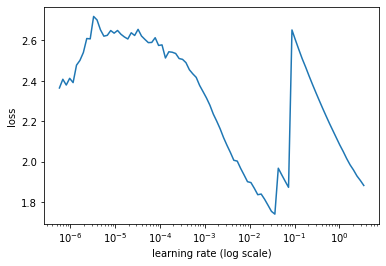

In [22]:
learner.lr_find(show_plot=True)

### Train

In [23]:
learner.autofit(10e-4, early_stopping=5)

reduce_on_plateau automatically enabled at patience=2


begin training using triangular learning rate policy with max lr of 0.001...
Train on 647 samples, validate on 81 samples
Epoch 1/1024
647/647 [==============================] - 5s 8ms/sample - loss: 1.7193 - accuracy: 0.5379 - val_loss: 0.7308 - val_accuracy: 0.5679
Epoch 2/1024
647/647 [==============================] - 4s 6ms/sample - loss: 0.7175 - accuracy: 0.6306 - val_loss: 0.6679 - val_accuracy: 0.5556
Epoch 3/1024
647/647 [==============================] - 4s 6ms/sample - loss: 0.5567 - accuracy: 0.7187 - val_loss: 0.6786 - val_accuracy: 0.5679
Epoch 4/1024
647/647 [==============================] - 4s 6ms/sample - loss: 0.4803 - accuracy: 0.7620 - val_loss: 0.6476 - val_accuracy: 0.6049
Epoch 5/1024
647/647 [==============================] - 4s 6ms/sample - loss: 0.4079 - accuracy: 0.8099 - val_loss: 0.6692 - val_accuracy: 0.6790
Epoch 6/1024
640/647 [============================>.] - ETA: 0s - loss: 0.3956 - accuracy: 0

## Examine results

In [24]:
learner.validate(class_names=preproc.get_classes())

              precision    recall  f1-score   support

           0       0.52      0.45      0.48        33
           1       0.65      0.71      0.68        48

    accuracy                           0.60        81
   macro avg       0.59      0.58      0.58        81
weighted avg       0.60      0.60      0.60        81



array([[15, 18],
       [14, 34]])

## Explain a prediction

In [31]:
import pandas as pd
X_test = pd.read_csv('../data/test_80_10_10.csv')['cleaned_contents']

In [32]:
predictor = ktrain.get_predictor(learner.model, preproc=preproc)

In [33]:
y_hat = predictor.predict(list(x_test))

In [34]:
(y_hat == y_test).sum()

49

In [35]:
predictor.explain('As the perpetrator is the sole breadwinner for his family, I reduce his sentence by two years.')

In [36]:
learner.evaluate(test)

              precision    recall  f1-score   support

           0       0.52      0.45      0.48        33
           1       0.65      0.71      0.68        48

    accuracy                           0.60        81
   macro avg       0.59      0.58      0.58        81
weighted avg       0.60      0.60      0.60        81



array([[15, 18],
       [14, 34]])

In [37]:
from sklearn.metrics.pairwise import cosine_similarity

In [38]:
wv_model['text_to_token']['suva']

127

In [39]:
preproc.tok.texts_to_sequences(['suva'])

[[128]]

In [43]:
cosine_similarity(Embeddings[128,:].reshape(1,-1), Embeddings).argsort()

array([[11288, 19951, 26369, ...,  7412,   488,   128]])

In [46]:
preproc.tok.sequences_to_texts([[480]])

['prasad']

In [42]:
{preproc.tok.texts_to_sequences([word]) : word for word in wv_model['vocab']}

TypeError: unhashable type: 'list'

In [140]:
embed_dict = {preproc.tok.texts_to_sequences([word])[0][0] : word for word in wv_model['vocab']}

In [190]:
preproc.tok.texts_to_sequences(['rape'])

[[593]]

In [191]:
embed_dict[593]

'rape'

In [192]:
preproc.tok.sequences_to_texts([[593]])

['rape']

In [146]:
Embeddings = np.stack([embed_word(preproc.tok.sequences_to_texts([[i]])[0], wv_model, 300) for i in range (1, 33000)])

In [196]:
Embeddings.shape

(32999, 300)

In [198]:
Embeddings = np.concatenate((np.zeros(300).reshape(1,-1), Embeddings))

In [210]:
learner.reset_weights()

Model weights have been reset.


In [211]:
learner.model.weights[0]

<tf.Variable 'embedding_4/embeddings:0' shape=(32999, 300) dtype=float32, numpy=
array([[-0.95571923,  0.80129987, -1.4521965 , ...,  1.0145426 ,
         1.7779183 , -0.66057944],
       [-0.7398424 ,  1.0029879 ,  0.9430608 , ...,  0.48449713,
         0.5587407 ,  1.963655  ],
       [-0.20715149,  2.017186  , -0.32258588, ..., -0.22842658,
         1.2660419 , -0.05658771],
       ...,
       [-0.05113932,  0.00685608,  0.00228031, ...,  0.04837001,
         0.00929243, -0.00382673],
       [ 0.02422185, -0.04101824, -0.03618522, ...,  0.02189103,
         0.02863402, -0.02953816],
       [-0.01571665,  0.0836259 ,  0.0910797 , ...,  0.03493011,
         0.01273112, -0.01555377]], dtype=float32)>

In [217]:
Embeddings.shape

(33000, 300)

In [218]:
learner.model.weights[0] = Embeddings[:-1]

In [301]:
model = _build_cnn(MAXLEN, len(Embeddings), DIMS, filters=32, kernels=[2, 3, 4, 5, 6], embeddings=Embeddings, dropout=0.1, density=64, loss_func='binary_crossentropy',)
learner = ktrain.get_learner(model, train_data=train, val_data=test)

In [302]:
learner.model.weights[0]

<tf.Variable 'embedding_15/embeddings:0' shape=(33000, 300) dtype=float32, numpy=
array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.95571923,  0.80129987, -1.4521965 , ...,  1.0145426 ,
         1.7779183 , -0.66057944],
       [-0.7398424 ,  1.0029879 ,  0.9430608 , ...,  0.48449713,
         0.5587407 ,  1.963655  ],
       ...,
       [-0.05113932,  0.00685608,  0.00228031, ...,  0.04837001,
         0.00929243, -0.00382673],
       [ 0.02422185, -0.04101824, -0.03618522, ...,  0.02189103,
         0.02863402, -0.02953816],
       [-0.01571665,  0.0836259 ,  0.0910797 , ...,  0.03493011,
         0.01273112, -0.01555377]], dtype=float32)>

simulating training for different learning rates... this may take a few moments...


/usr/local/lib/python3.6/dist-packages/ktrain/core.py:476: UserWarning: max_epochs is being set to 5 since steps per epoch is small. If you wish to estimate LR using more epochs, set max_epochs manually.
  'If you wish to estimate LR using more epochs, set max_epochs manually.')


Train on 647 samples
Epoch 1/5
647/647 [==============================] - 5s 7ms/sample - loss: 1.8140 - accuracy: 0.5626
Epoch 2/5
647/647 [==============================] - 4s 5ms/sample - loss: 1.6460 - accuracy: 0.5317
Epoch 3/5
647/647 [==============================] - 4s 5ms/sample - loss: 1.2638 - accuracy: 0.5425
Epoch 4/5
647/647 [==============================] - 4s 6ms/sample - loss: 2.5898 - accuracy: 0.5533
Epoch 5/5
647/647 [==============================] - 4s 6ms/sample - loss: 7.5969 - accuracy: 0.4869


done.
Visually inspect loss plot and select learning rate associated with falling loss


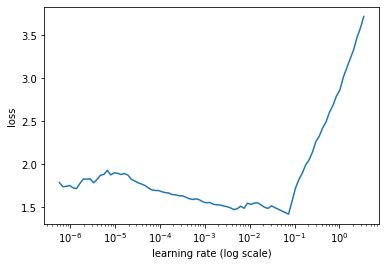

In [303]:
learner.lr_find(show_plot=True)

In [304]:
learner.autofit(10e-3)

early_stopping automatically enabled at patience=5
reduce_on_plateau automatically enabled at patience=2


begin training using triangular learning rate policy with max lr of 0.01...
Train on 647 samples, validate on 162 samples
Epoch 1/1024
647/647 [==============================] - 5s 8ms/sample - loss: 2.4335 - accuracy: 0.5549 - val_loss: 1.1787 - val_accuracy: 0.3951
Epoch 2/1024
647/647 [==============================] - 4s 6ms/sample - loss: 0.8704 - accuracy: 0.5240 - val_loss: 0.7714 - val_accuracy: 0.4074
Epoch 3/1024
647/647 [==============================] - 4s 6ms/sample - loss: 0.6915 - accuracy: 0.5595 - val_loss: 0.6673 - val_accuracy: 0.5988
Epoch 4/1024
647/647 [==============================] - 4s 6ms/sample - loss: 0.6617 - accuracy: 0.5734 - val_loss: 0.6796 - val_accuracy: 0.5988
Epoch 5/1024
647/647 [==============================] - 4s 6ms/sample - loss: 0.6675 - accuracy: 0.5951 - val_loss: 0.6531 - val_accuracy: 0.6111
Epoch 6/1024
647/647 [===================

In [305]:
predictor = ktrain.get_predictor(learner.model, preproc)

In [306]:
y_hat = predictor.predict(list(x_test))

In [307]:
y_HAT = np.array([i[1][1] > i[0][1] for i in y_hat])

In [325]:
TP = ((y_HAT == True) & (y_test == 1)).sum()

In [326]:
TP

70

In [310]:
FN = ((y_HAT == False) & (y_test == 1)).sum()

In [311]:
FN

27

In [312]:
FP = ((y_HAT == True) & (y_test == 0)).sum()

In [313]:
FP

17

In [327]:
2*TP/(2*TP + FN + FP)

0.7608695652173914

In [329]:
(y_HAT == y_test).sum() / len(y_test)

0.7283950617283951

In [330]:
TP / (TP + FP)

0.8045977011494253

In [331]:
TP / (TP + FN)

0.7216494845360825

In [323]:
TN = len(y_hat) - TP - FN - FP

In [324]:
TN

0

In [332]:
learner.save_model('cnn_Ioya2Vec_model')

In [333]:
tf.keras.models.save_model(model, filepath='./cnn_Ioya2Vec_model')

In [334]:
predictor.save('cnn_Ioya2Vec_predictor')